In [32]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.datasets import fetch_lfw_people  # Importing fetch_lfw_people from scikit-learn
import cv2


In [33]:
# Downloading the LFW dataset using scikit-learn
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

train_images = lfw_people.images
train_labels = lfw_people.target

train_images = train_images / 255.0

# Function to preprocess images (remains unchanged)
def preprocess_image(image, target_shape=(105, 105)):
    image = cv2.resize(image, target_shape)
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    return image

# Preprocess train images
train_images = np.array([preprocess_image(img) for img in train_images])

# Splitting the dataset into train and test
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [34]:
def siamese_model(input_shape):
    input = Input(input_shape)


    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)

    model = Model(inputs=input, outputs=x)
    return model

input_shape = (105, 105, 1)
siamese_model = siamese_model(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Generation of the encodings (feature vectors) for the two images
encoded_a = siamese_model(input_a)
encoded_b = siamese_model(input_b)

# Calculate the Euclidean distance between the encodings
L1_distance = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])
output = Dense(1, activation='sigmoid')(L1_distance)

# Model to take two inputs and output whether they are the same or different
siamese_network = Model(inputs=[input_a, input_b], outputs=output)
siamese_network.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

siamese_network.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, 4096)                 3894764   ['input_5[0][0]',             
                                                          8          'input_6[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 4096)                 0         ['model_2[0][0]',       

In [35]:
import random

def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    n = min([len(np.where(labels == i)[0]) for i in range(len(np.unique(labels)))])

    for d in range(len(np.unique(labels))):
        idx = np.where(labels == d)[0]
        for i in range(n - 1):
            pairs.append([images[idx[i]], images[idx[i + 1]]])
            inc = random.randrange(1, n)
            dn = (d + inc) % len(np.unique(labels))
            idx2 = np.where(labels == dn)[0]
            pairs.append([images[idx[i]], images[idx2[i]]])
            pair_labels += [1, 0]

    return np.array(pairs), np.array(pair_labels)

train_pairs, train_y = create_pairs(train_images, train_labels)
test_pairs, test_y = create_pairs(test_images, test_labels)

siamese_network.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
                    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y),
                    batch_size=32,
                    epochs=25)

Epoch 1/25
25/25 [==============================] - 5s 82ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 2s 70ms/step - loss: 0.6932 - accuracy: 0.4749 - val_loss: 0.6932 - val_accuracy: 0.5143
Epoch 3/25
25/25 [==============================] - 2s 70ms/step - loss: 0.6932 - accuracy: 0.5138 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/25
25/25 [==============================] - 2s 70ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 5/25
25/25 [==============================] - 2s 69ms/step - loss: 0.6936 - accuracy: 0.5175 - val_loss: 0.6949 - val_accuracy: 0.4857
Epoch 6/25
25/25 [==============================] - 2s 72ms/step - loss: 0.6926 - accuracy: 0.5639 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/25
25/25 [==============================] - 2s 78ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/25
25

In [36]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resizing the output to fit the video element
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Waiting for Capture to be clicked
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Capturing the image
captured_image_filename = take_photo()

captured_image = cv2.imread(captured_image_filename) # Read the image data from the file


# Convert to grayscale and preprocess the image
def preprocess_image(image, target_shape=(105, 105)):
    image = cv2.resize(image, target_shape)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)
    return image

captured_image = preprocess_image(captured_image)


<IPython.core.display.Javascript object>

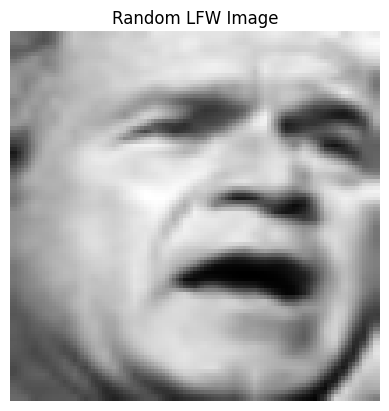

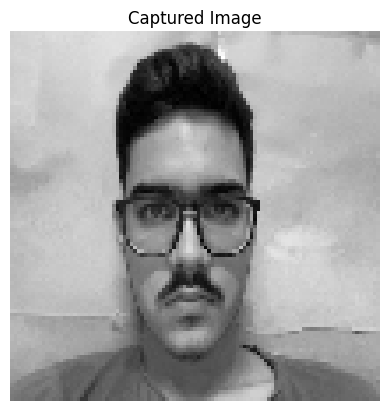

1/1 [==============================] - 0s 114ms/step
The images are different.


In [37]:
import random

# Selection of a random image from LFW dataset
random_index = random.randint(0, len(test_images) - 1)
lfw_image = test_images[random_index]

plt.imshow(lfw_image.squeeze(), cmap='gray')
plt.title("Random LFW Image")
plt.axis('off')
plt.show()

plt.imshow(captured_image.squeeze(), cmap='gray')
plt.title("Captured Image")
plt.axis('off')
plt.show()

prediction = siamese_network.predict([np.expand_dims(captured_image, axis=0), np.expand_dims(lfw_image, axis=0)])
if prediction < 0.5:
    print("The images are different.")
else:
    print("The images are the same.")